# Biomedical Image Analysis

In [1]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator

2022-11-11 13:37:57.910675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))
    
    norm_images = []
    for image in tqdm(norm_files):
        image = cv2.imread(norm_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_images.append(image)
        
    norm_images = np.array(norm_images)
    
    return norm_images, norm_labels
def load_pneumonia(pneu_path):
    pneu_files = np.array(os.listdir(pneu_path))
    pneu_labels = np.array([pneu_file.split('_')[1] for pneu_file in pneu_files])
    
    pneu_images = []
    for image in tqdm(pneu_files):
        image = cv2.imread(pneu_path + image)
        image = cv2.resize(image, dsize=(200,200))X_train = np.append(norm_images, pneu_images, axis=0)
y_train = np.append(norm_labels, pneu_labels)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneu_images.append(image)
        
    pneu_images = np.array(pneu_images)
    
    return pneu_images, pneu_labels

In [8]:
norm_images, norm_labels = load_normal('/Users/matea/Downloads/chest_xray/train/NORMAL/')
pneu_images, pneu_labels = load_pneumonia('/Users/matea/Downloads/chest_xray/train/PNEUMONIA/')

100%|███████████████████████████████████████| 3875/3875 [00:45<00:00, 85.72it/s]


In [9]:
X_train = np.append(norm_images, pneu_images, axis=0)
y_train = np.append(norm_labels, pneu_labels)

In [6]:
def plot_images(X, y):
    fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

    indices = np.random.choice(len(X), 14)
    counter = 0

    for i in range(2):
        for j in range(7):
            axes[i,j].set_title(y[indices[counter]])
            axes[i,j].imshow(X[indices[counter]], cmap='gray')
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
            counter += 1
    plt.show()

In [12]:
norm_images_test, norm_labels_test = load_normal('/Users/matea/Downloads/chest_xray/test/NORMAL/')
pneu_images_test, pneu_labels_test = load_pneumonia('/Users/matea/Downloads/chest_xray/test/PNEUMONIA/')

100%|████████████████████████████████████████| 390/390 [00:03<00:00, 103.65it/s]


In [13]:
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
y_test = np.append(norm_labels_test, pneu_labels_test)

In [2]:
#with open('pneumonia_data.pickle', 'wb') as f:
#    pickle.dump((X_train, X_test, y_train, y_test), f)# Use this to load variables
with open('pneumonia_data.pickle', 'rb') as f:
    (X_train, X_test, y_train, y_test) = pickle.load(f)

In [3]:
np.unique(y_train, return_counts=True)

(array(['bacteria', 'normal', 'virus'], dtype='<U8'),
 array([2530, 1341, 1345]))

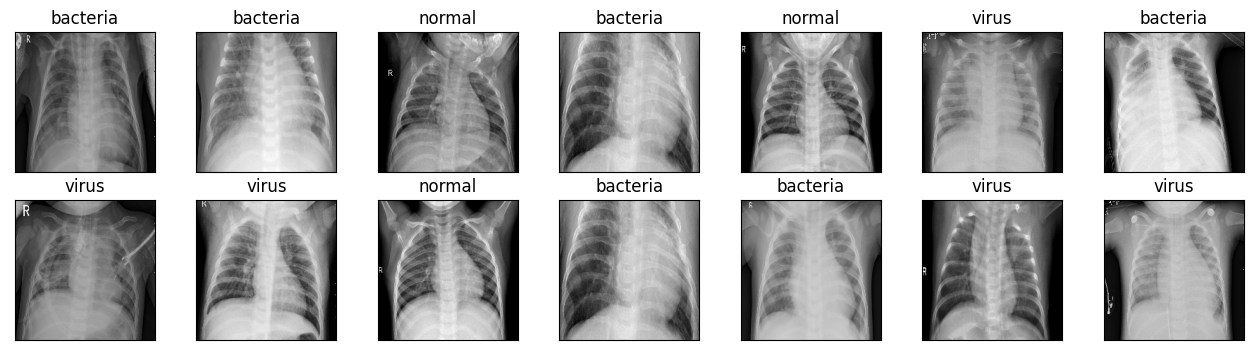

In [7]:
plot_images(X_train, y_train)

In [8]:
np.unique(y_train, return_counts=True)

(array(['bacteria', 'normal', 'virus'], dtype='<U8'),
 array([2530, 1341, 1345]))

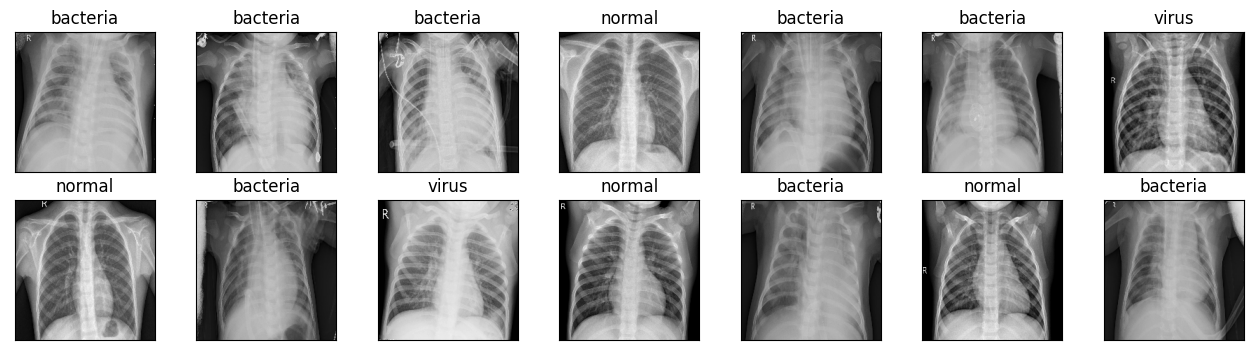

In [9]:
plot_images(X_test, y_test)

In [10]:
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]

In [11]:
one_hot_encoder = OneHotEncoder(sparse=False)

In [12]:
y_train_one_hot = one_hot_encoder.fit_transform(y_train)
y_test_one_hot = one_hot_encoder.transform(y_test)

In [13]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [14]:
datagen = ImageDataGenerator(
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

In [15]:
datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train_one_hot, batch_size=32)

In [16]:
input1 = Input(shape=(X_train.shape[1], X_train.shape[2], 1))

cnn = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(input1)
cnn = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Conv2D(16, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = Conv2D(32, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Flatten()(cnn)
cnn = Dense(100, activation='relu')(cnn)
cnn = Dense(50, activation='relu')(cnn)
output1 = Dense(3, activation='softmax')(cnn)

model = Model(inputs=input1, outputs=output1)

2022-11-11 13:39:43.821089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 16)      2064      
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 32)      2080      
                                                             

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
history = model.fit_generator(train_gen, epochs=30, validation_data=(X_test, y_test_one_hot))

/var/folders/kx/cg3gykd97p5_8lclgfj1rkr40000gn/T/ipykernel_53964/452991634.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, epochs=30, validation_data=(X_test, y_test_one_hot))


Epoch 1/30
163/163 [==============================] - 235s 1s/step - loss: 2.7363 - acc: 0.6016 - val_loss: 0.7225 - val_acc: 0.7676
Epoch 2/30
163/163 [==============================] - 213s 1s/step - loss: 0.6951 - acc: 0.6979 - val_loss: 0.9994 - val_acc: 0.6891
Epoch 3/30
163/163 [==============================] - 237s 1s/step - loss: 0.6721 - acc: 0.7109 - val_loss: 1.0153 - val_acc: 0.6651
Epoch 4/30
163/163 [==============================] - 220s 1s/step - loss: 0.6638 - acc: 0.7189 - val_loss: 1.0100 - val_acc: 0.7115
Epoch 5/30
163/163 [==============================] - 315s 2s/step - loss: 0.6888 - acc: 0.7120 - val_loss: 0.8779 - val_acc: 0.6699
Epoch 6/30
163/163 [==============================] - 221s 1s/step - loss: 0.6565 - acc: 0.7235 - val_loss: 0.6931 - val_acc: 0.7788
Epoch 7/30
163/163 [==============================] - 256s 2s/step - loss: 0.5832 - acc: 0.7527 - val_loss: 0.9198 - val_acc: 0.7099
Epoch 8/30
163/163 [==============================] - 263s 2s/step - 

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()